## Shopping Mall 지점별 매출액 예측

1. Import & Data check  
2. EDA  
3. Feature Engineering
4. Modeling & submission

## 1. Import & Data Check

1) 데이터 확인  
2) 이상치 탐색 및 제거  
3) 결측치 확인  
4) 비대칭도 확인  

In [2]:
# ! pip install missingno

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
import datetime

plt.style.use('seaborn')
sns.set(font_scale=1.5)

import missingno as msno

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
os.listdir('./dataset/shoppingmall')

['sample_submission.csv', 'test.csv', 'train.csv']

In [4]:
df_train = pd.read_csv('./dataset/shoppingmall/train.csv')
df_test = pd.read_csv('./dataset/shoppingmall/test.csv')

### 1) 데이터 확인

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            6255 non-null   int64  
 1   Store         6255 non-null   int64  
 2   Date          6255 non-null   object 
 3   Temperature   6255 non-null   float64
 4   Fuel_Price    6255 non-null   float64
 5   Promotion1    2102 non-null   float64
 6   Promotion2    1592 non-null   float64
 7   Promotion3    1885 non-null   float64
 8   Promotion4    1819 non-null   float64
 9   Promotion5    2115 non-null   float64
 10  Unemployment  6255 non-null   float64
 11  IsHoliday     6255 non-null   bool   
 12  Weekly_Sales  6255 non-null   float64
dtypes: bool(1), float64(9), int64(2), object(1)
memory usage: 592.6+ KB


In [14]:
df_train.head()

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales
0,1,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,8.106,False,1643690.90
1,2,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,8.106,True,1641957.44
2,3,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,8.106,False,1611968.17
3,4,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,8.106,False,1409727.59
4,5,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,8.106,False,1554806.68


In [10]:
df_train.shape, df_test.shape
# 6255개의 데이터

((6255, 13), (180, 12))

In [13]:
df_test.columns
# target 변수 Weekly_Sales 라는 점 다시 확인

Index(['id', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'Promotion1',
       'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment',
       'IsHoliday'],
      dtype='object')

### 2) 이상치 탐색 및 제거 - 수치형 변수 사용

In [17]:
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        
        outlier_step = 1.5*IQR
        
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
        
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k,v in outlier_indices.items() if v> n)
    
    return multiple_outliers

Outlier_to_drop = detect_outliers(df_train, 2, ['id', 'Store','Temperature', 'Fuel_Price', 'Promotion1',
       'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment'])

In [18]:
df_train.loc[Outlier_to_drop]
# 없

,id,Store,Date,Temperature,Fuel_Price,Promotion1,Promotion2,Promotion3,Promotion4,Promotion5,Unemployment,IsHoliday,Weekly_Sales


### 3) 결측치 확인

In [20]:
df_train.isnull().sum()
# 프로모션 1~ 5에 결측치 존재
# 이 프로모션은 도대체 뭘까

id                 0
Store              0
Date               0
Temperature        0
Fuel_Price         0
Promotion1      4153
Promotion2      4663
Promotion3      4370
Promotion4      4436
Promotion5      4140
Unemployment       0
IsHoliday          0
Weekly_Sales       0
dtype: int64

In [21]:
df_test.isnull().sum() 
# test 데이터도 마찬가지

id                0
Store             0
Date              0
Temperature       0
Fuel_Price        0
Promotion1        2
Promotion2      135
Promotion3       19
Promotion4       34
Promotion5        0
Unemployment      0
IsHoliday         0
dtype: int64

### 4) 비대칭도 확인 - 수치형 변수에 대해서만 확인

In [27]:
numerical_features = df_train.dtypes[(df_train.dtypes != object) & (df_train.dtypes != bool)].index
# and가 아니라 &로 써야함

In [28]:
numerical_features

Index(['id', 'Store', 'Temperature', 'Fuel_Price', 'Promotion1', 'Promotion2',
       'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment',
       'Weekly_Sales'],
      dtype='object')

In [29]:
for col in numerical_features:
    print('{:15}'.format(col),
          'Skewness : {:05.2f}'.format(df_train[col].skew()),
         '  ', 
         'Kurtosis : {:06.2f}'.format(df_train[col].kurt()),)

id              Skewness : 00.00    Kurtosis : -01.20
Store           Skewness : 00.00    Kurtosis : -01.20
Temperature     Skewness : -0.33    Kurtosis : -00.65
Fuel_Price      Skewness : -0.08    Kurtosis : -01.22
Promotion1      Skewness : 03.28    Kurtosis : 017.06
Promotion2      Skewness : 05.47    Kurtosis : 038.09
Promotion3      Skewness : 08.31    Kurtosis : 076.23
Promotion4      Skewness : 04.74    Kurtosis : 028.70
Promotion5      Skewness : 08.18    Kurtosis : 106.81
Unemployment    Skewness : 01.21    Kurtosis : 002.67
Weekly_Sales    Skewness : 00.67    Kurtosis : 000.07


Skewness : 0.673334
Skewness : 0.068794


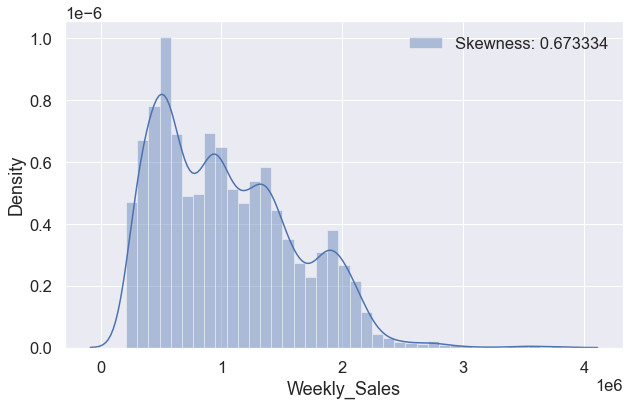

In [30]:
f, ax = plt.subplots(1, 1, figsize = (10,6)) 
g = sns.distplot(df_train["Weekly_Sales"], color = "b", label="Skewness: {:2f}".format(df_train["Weekly_Sales"].skew()), ax=ax) 
g = g.legend(loc = "best")

print("Skewness : %f" % df_train['Weekly_Sales'].skew())
print("Skewness : %f" % df_train['Weekly_Sales'].kurt())

# 다소 치우침이 있으니 조정해보도록 하자

## 2. EDA

In [35]:
pd.options.display.float_format = '{:.2f}'.format

In [53]:
# 확인하고 싶은게 먼저 있음
# Store 별 관측치가 몇개있는지
df_train['Store'].value_counts() # 139개의 관측값이 존재

# Store 는 Categorical 변수로 보는것이 맞지 않을까?

4     139
2     139
10    139
14    139
18    139
22    139
26    139
30    139
34    139
38    139
42    139
3     139
7     139
11    139
15    139
19    139
23    139
27    139
31    139
35    139
39    139
6     139
45    139
8     139
41    139
12    139
16    139
20    139
24    139
28    139
32    139
36    139
40    139
44    139
1     139
5     139
9     139
13    139
17    139
21    139
25    139
29    139
33    139
37    139
43    139
Name: Store, dtype: int64

In [64]:
df_train = df_train.astype({'Store':'object'})

In [65]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            6255 non-null   int64         
 1   Store         6255 non-null   object        
 2   Date          6255 non-null   datetime64[ns]
 3   Temperature   6255 non-null   float64       
 4   Fuel_Price    6255 non-null   float64       
 5   Promotion1    2102 non-null   float64       
 6   Promotion2    1592 non-null   float64       
 7   Promotion3    1885 non-null   float64       
 8   Promotion4    1819 non-null   float64       
 9   Promotion5    2115 non-null   float64       
 10  Unemployment  6255 non-null   float64       
 11  IsHoliday     6255 non-null   bool          
 12  Weekly_Sales  6255 non-null   float64       
 13  year          6255 non-null   int64         
 14  month         6255 non-null   int64         
 15  dayofweek     6255 non-null   int64   

1) not 수치형 데이터 확인하기
2) 수치형 데이터 확인하기

### 1) Date, IsHoliday 변수 탐색

In [ ]:
# Date 변수 탐색

In [6]:
df_train['Date'] = pd.to_datetime(df_train['Date'])

In [7]:
df_train.info()
# datetime 으로 변경 완.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6255 entries, 0 to 6254
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            6255 non-null   int64         
 1   Store         6255 non-null   int64         
 2   Date          6255 non-null   datetime64[ns]
 3   Temperature   6255 non-null   float64       
 4   Fuel_Price    6255 non-null   float64       
 5   Promotion1    2102 non-null   float64       
 6   Promotion2    1592 non-null   float64       
 7   Promotion3    1885 non-null   float64       
 8   Promotion4    1819 non-null   float64       
 9   Promotion5    2115 non-null   float64       
 10  Unemployment  6255 non-null   float64       
 11  IsHoliday     6255 non-null   bool          
 12  Weekly_Sales  6255 non-null   float64       
dtypes: bool(1), datetime64[ns](1), float64(9), int64(2)
memory usage: 592.6 KB


In [8]:
df_train['year'] = df_train['Date'].dt.year
df_train['month'] = df_train['Date'].dt.month

In [9]:
df_test['Date'] = pd.to_datetime(df_test['Date'])

df_test['year'] = df_test['Date'].dt.year
df_test['month'] = df_test['Date'].dt.month

In [10]:
df_test.info() # test 셋에 대해서도 변경해두기

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            180 non-null    int64         
 1   Store         180 non-null    int64         
 2   Date          180 non-null    datetime64[ns]
 3   Temperature   180 non-null    float64       
 4   Fuel_Price    180 non-null    float64       
 5   Promotion1    178 non-null    float64       
 6   Promotion2    45 non-null     float64       
 7   Promotion3    161 non-null    float64       
 8   Promotion4    146 non-null    float64       
 9   Promotion5    180 non-null    float64       
 10  Unemployment  180 non-null    float64       
 11  IsHoliday     180 non-null    bool          
 12  year          180 non-null    int64         
 13  month         180 non-null    int64         
dtypes: bool(1), datetime64[ns](1), float64(8), int64(4)
memory usage: 18.6 KB


In [11]:
# 분리했으니 연도별 자료값 확인

df_train['year'].value_counts()

2011    2340
2010    2160
2012    1755
Name: year, dtype: int64

In [12]:
# 월별 자료 확인

df_train['month'].value_counts()

4     630
9     585
7     585
8     540
5     540
6     540
3     540
2     495
10    495
12    450
1     450
11    405
Name: month, dtype: int64

[Text(0, 0.5, 'Weekly_Sales'), Text(0.5, 1.0, 'Weekly Sales by dayofweek')]

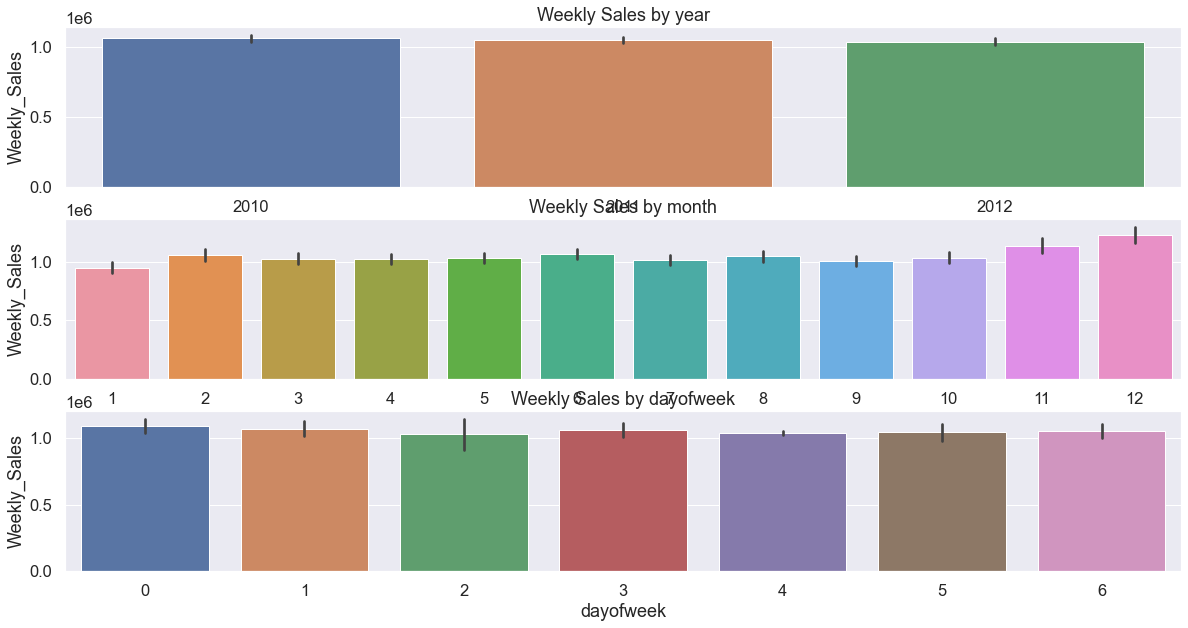

In [36]:
figure, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1) 
figure.set_size_inches(20,10) 
sns.barplot(data=df_train, x = "year", y = "Weekly_Sales", ax = ax1) 
sns.barplot(data=df_train, x = "month", y = "Weekly_Sales", ax = ax2)
sns.barplot(data=df_train, x = "dayofweek", y = "Weekly_Sales", ax = ax3)

ax1.set(ylabel = "Weekly_Sales", title = "Weekly Sales by year") 
ax2.set(ylabel = "Weekly_Sales", title = "Weekly Sales by month") 
ax3.set(ylabel = "Weekly_Sales", title = "Weekly Sales by dayofweek") 

In [14]:
df_train['dayofweek'] = df_train['Date'].dt.dayofweek

In [15]:
df_train['dayofweek'].value_counts()

4    4230
0     450
1     405
6     405
3     405
5     270
2      90
Name: dayofweek, dtype: int64

<AxesSubplot:xlabel='dayofweek', ylabel='Weekly_Sales'>

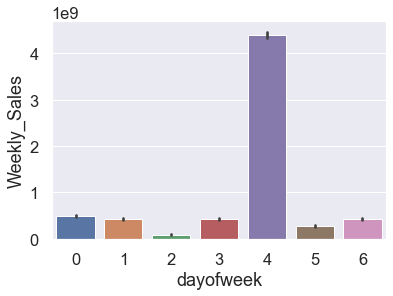

In [71]:
sns.barplot(data=df_train, x='dayofweek', y='Weekly_Sales',estimator=np.sum)

# 0: 월요일 ~ 6: 일요일
# 금요일의 구매량 합이 월등히 많음

<AxesSubplot:xlabel='month', ylabel='Weekly_Sales'>

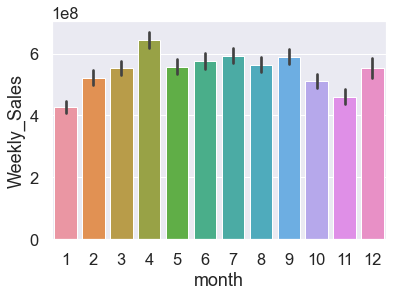

In [37]:
sns.barplot(data=df_train, x='month', y='Weekly_Sales',estimator=np.sum)

<AxesSubplot:xlabel='month', ylabel='Weekly_Sales'>

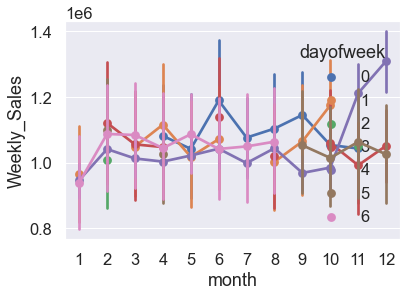

In [76]:
sns.pointplot(data = df_train, x = "month",hue = 'dayofweek', y = "Weekly_Sales") 

In [ ]:
# IsHoliday

In [48]:
df_train['IsHoliday'].value_counts() # 주말이 있던 주는 450번

False    5805
True      450
Name: IsHoliday, dtype: int64

<AxesSubplot:xlabel='IsHoliday', ylabel='Weekly_Sales'>

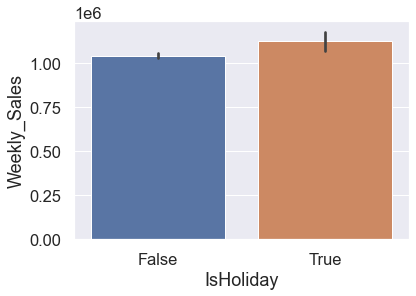

In [78]:
sns.barplot(data=df_train, x= 'IsHoliday', y ='Weekly_Sales')
# 공휴일에 당연 판매량이 높음

### 2) numeric feautures 탐색

In [16]:
df_train.columns

Index(['id', 'Store', 'Date', 'Temperature', 'Fuel_Price', 'Promotion1',
       'Promotion2', 'Promotion3', 'Promotion4', 'Promotion5', 'Unemployment',
       'IsHoliday', 'Weekly_Sales', 'year', 'month', 'dayofweek'],
      dtype='object')

In [17]:
corr_data = df_train[['Temperature', 'Fuel_Price', 'Promotion1','Promotion2', 'Promotion3', 'Promotion4', 'Promotion5',
                      'Unemployment', 'Weekly_Sales']]

<AxesSubplot:title={'center':'Correlation of Numeric Features with Weekly Sales'}>

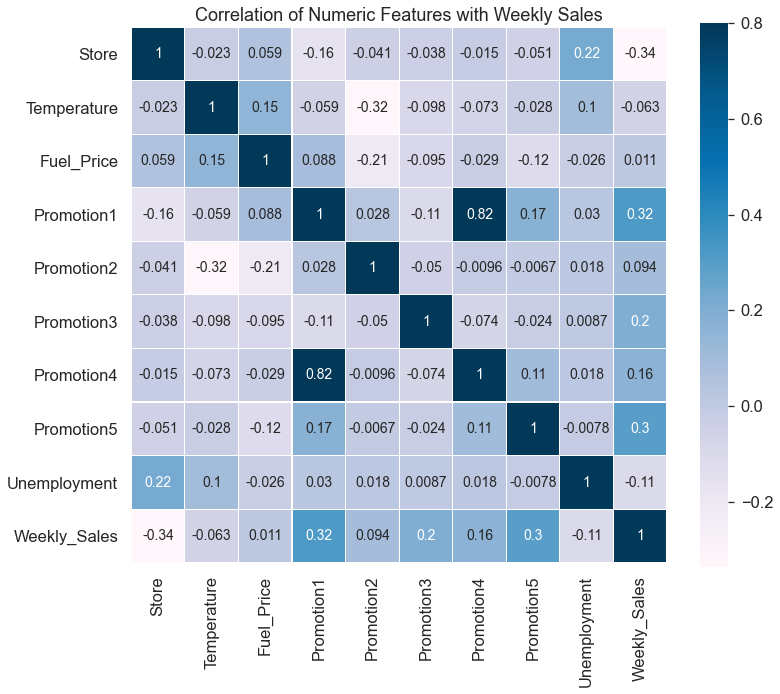

In [81]:
colormap = plt.cm.PuBu
f , ax = plt.subplots(figsize = (12,10)) 
plt.title('Correlation of Numeric Features with Weekly Sales', y=1,size=18) 
sns.heatmap(corr_data.corr(), vmax=.8, linewidths=0.1,square=True,annot=True,cmap=colormap, 
            linecolor="white",annot_kws = {'size':14})

Temperature  
Fuel_Price  
Promotion1, Promotion2, Promotion3, Promotion4, Promotion5  
Unemployment  

#### 1. Store  
스토어별 평균 판매량의 차이를 알아보기  

<AxesSubplot:xlabel='Store', ylabel='Weekly_Sales'>

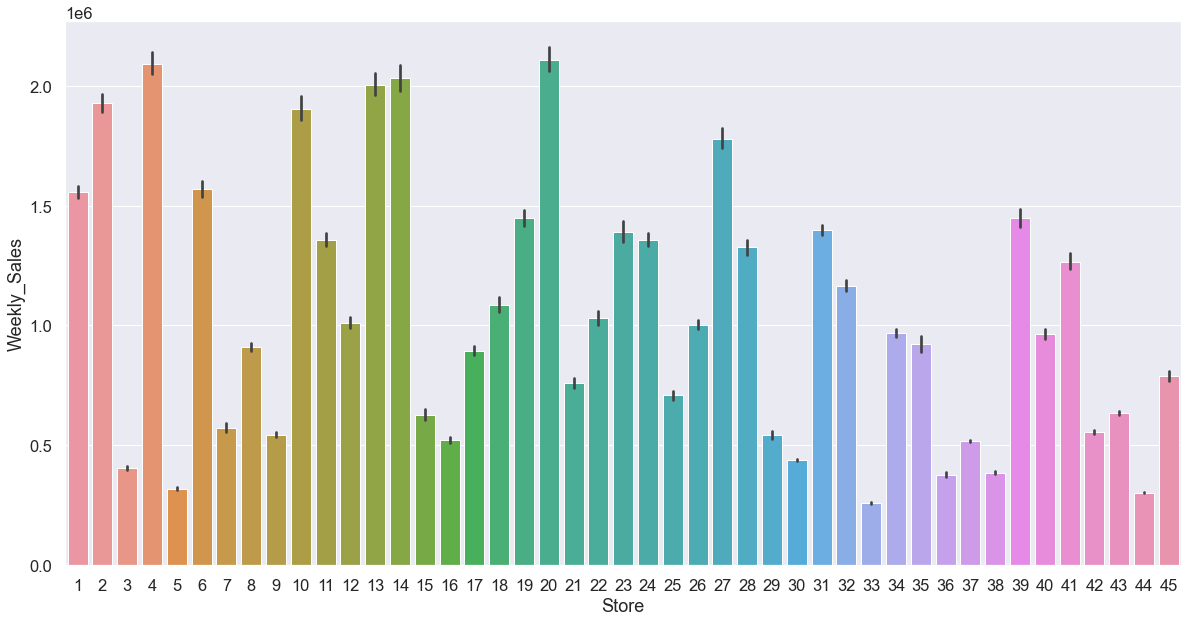

In [67]:
# fig, ax = plt.subplots(nrows=4, figsize=(30,30))
# sns.barplot(data=df_train, x ='Store', y = 'Weekly_Sales',ax = ax[0])

plt.figure(figsize=(20,10))
sns.barplot(data=df_train, x ='Store', y = 'Weekly_Sales', estimator=np.mean)
# seaborn은 오름차순 안됨

In [66]:
# df_train.groupby('Store')['Weekly_Sales'].mean()
df_train.groupby('Store').agg({'Weekly_Sales' :['mean','min','max']}).sort_values(by=('Weekly_Sales','mean'), ascending = False)
# 20, 4, 14, 13, 2, 10, 27, 6, 1

Weekly_Sales                      
              mean        min        max
Store                                   
20      2107607.30 1761016.51 3766687.43
4       2093195.90 1762539.30 3676388.98
14      2031497.13 1479514.66 3818686.45
13      2003046.80 1633663.12 3595903.20
2       1926625.37 1650394.44 3436007.68
10      1904069.56 1627707.31 3749057.69
27      1778997.10 1263534.86 3078162.08
6       1567699.61 1261253.18 2727575.18
1       1555087.92 1316899.31 2387950.20
19      1447703.71 1181204.53 2678206.42
39      1447695.89 1158698.44 2554482.84
31      1396622.04 1198071.60 2068942.97
23      1389658.03 1016756.10 2734277.10
11      1358239.03 1100418.69 2306265.36
24      1356981.31 1057290.41 2386015.75
28      1325450.49 1079669.11 2026026.39
41      1265392.01  991941.73 2263722.68
32      1165615.24  955463.84 1959526.96
18      1084692.28  540922.94 2027507.15
22      1028699.79  774262.28 1962445.04
12      1010337.01  802105.50 1768249.89
26      1002460.81  809833.21 1573982.47
34       966991.00  836717.75 1620748.25
40       963879.42  764014.75 1648829.18
35       921485.92  576332.05 1781866.98
8        908311.16  772539.12 1511641.09
17       892149.85  635862.55 1309226.79
45       787402.99  617207.58 1682862.03
21       758967.59  596218.24 1587257.78
25       707121.24  558794.63 1295391.19
43       633754.88  505405.85  725043.04
15       625138.56  454183.42 1368318.17
7        572496.49  372673.61 1059715.27
42       556144.22  428953.60  674919.45
9        543397.54  452905.22  905324.68
29       539966.22  395987.24 1130926.79
16       519686.02  368600.00 1004730.69
37       518331.65  451327.61  605791.46
30       438550.93  369722.32  519354.88
3        402175.74  339597.38  605990.41
38       384300.22  303908.81  499267.66
36       376079.07  270677.98  489372.02
5        317801.34  260636.71  507900.07
44       301676.74  241937.11  376233.89
33       259675.20  209986.25  331173.51

In [68]:
# 미무리한다. Store는 Categorical변수로 변경한다리

#### 2. Temperature
1. Store주변 기온이 날짜에 따라 변할까 아니면 평균값만 제공할까?  
2. 기온이 높으면 구매량이 더 높을까? 아무래도 두꺼운 옷이 있기 때문에 겨울에 많이 살것 같은데

<AxesSubplot:xlabel='month', ylabel='Weekly_Sales'>

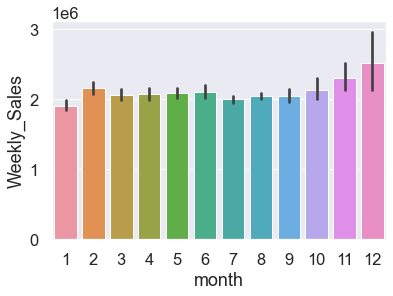

In [73]:
# 월에 따른 기온 변화
sns.barplot(data = df_train[df_train['Store'] == 20], x = 'month', y = 'Weekly_Sales')
# 차이가 있는거구만
# 대체적으로 12월로 갈수록 판매량이 증가하긴 함

In [83]:
print(df_train['Temperature'].max()) # 100도? 말이 되나요?
print(df_train['Temperature'].mean())

100.14
60.63919904076722


In [78]:
df_train.groupby('Store').agg({'Temperature': ['mean','min','max']})

Temperature             
             mean   min    max
Store                         
1           68.34 35.40  91.65
2           68.24 33.02  93.34
3           71.40 43.57  89.12
4           62.26 28.84  86.09
5           69.41 37.74  91.07
6           69.70 38.37  91.46
7           39.60 -2.06  68.84
8           62.56 24.48  87.26
9           67.82 31.82  91.63
10          72.16 42.58  95.36
11          72.47 44.61  91.44
12          70.21 37.64  99.22
13          53.69 16.94  83.68
14          57.77 24.05  82.99
15          51.76 19.53  79.97
16          45.06 12.39  77.31
17          46.39  6.23  74.20
18          53.33 14.84  79.75
19          52.23 20.66  79.37
20          55.43 20.39  79.20
21          68.88 34.14  94.22
22          54.83 20.61  79.22
23          48.75 10.91  77.16
24          54.00 17.91  79.29
25          52.13 18.30  78.10
26          43.55  5.54  71.08
27          57.27 23.64  82.69
28          70.21 37.64  99.22
29          54.83 20.61  79.22
30          68.88 34.14  94.22
31          68.88 34.14  94.22
32          52.83 15.47  81.95
33          76.68 46.25 100.14
34          58.44 23.82  81.96
35          57.27 23.64  82.69
36          71.10 41.16  87.64
37          71.10 41.16  87.64
38          70.21 37.64  99.22
39          70.57 40.34  88.65
40          47.60  9.51  76.67
41          48.50 14.56  76.54
42          72.16 42.58  95.36
43          68.80 33.21  91.36
44          53.69 16.94  83.68
45          57.77 24.05  82.99

<AxesSubplot:xlabel='Temperature', ylabel='Density'>

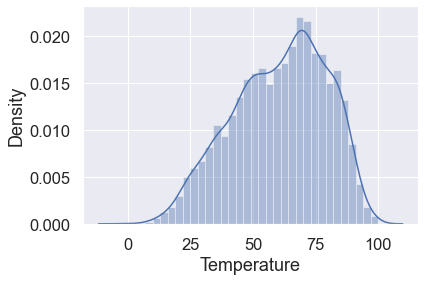

In [75]:
sns.distplot(df_train['Temperature'])
# 영하 온도가 없는데 
# 화씨온도

In [88]:
plt.figure(figsize=(20,10))
# sns.histplot(x=df_train['Temperature'], y=df_train['Weekly_Sales'])
# sns.scatterplot(x=df_train['Temperature'], y=df_train['Weekly_Sales'])

<Figure size 1440x720 with 0 Axes>

<Figure size 1440x720 with 0 Axes>

In [107]:
# 화씨온도 섭씨온도로 변경 
def ondo(x):
    return (x-32)*(5/9)

df_train['Temperature'] = df_train['Temperature'].apply(ondo)

<AxesSubplot:xlabel='Temperature', ylabel='Density'>

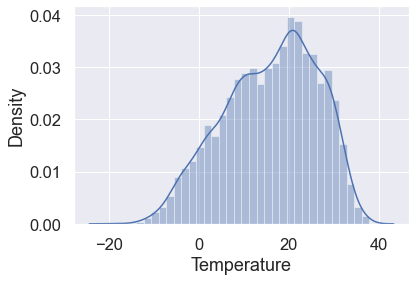

In [108]:
sns.distplot(df_train['Temperature'])

In [109]:
df_train.groupby('Store').agg({'Temperature': ['mean','min','max']}).sort_values(by=('Temperature','mean'),ascending = False)

Temperature             
             mean    min   max
Store                         
33          24.82   7.92 37.86
11          22.48   7.01 33.02
42          22.31   5.88 35.20
10          22.31   5.88 35.20
3           21.89   6.43 31.73
36          21.72   5.09 30.91
37          21.72   5.09 30.91
39          21.43   4.63 31.47
38          21.23   3.13 37.34
28          21.23   3.13 37.34
12          21.23   3.13 37.34
6           20.95   3.54 33.03
5           20.78   3.19 32.82
21          20.49   1.19 34.57
30          20.49   1.19 34.57
31          20.49   1.19 34.57
43          20.45   0.67 32.98
1           20.19   1.89 33.14
2           20.14   0.57 34.08
9           19.90  -0.10 33.13
8           16.98  -4.18 30.70
4           16.81  -1.76 30.05
34          14.69  -4.54 27.76
45          14.31  -4.42 28.33
14          14.31  -4.42 28.33
35          14.04  -4.64 28.16
27          14.04  -4.64 28.16
20          13.02  -6.45 26.22
29          12.68  -6.33 26.23
22          12.68  -6.33 26.23
24          12.22  -7.83 26.27
44          12.05  -8.37 28.71
13          12.05  -8.37 28.71
18          11.85  -9.53 26.53
32          11.57  -9.18 27.75
19          11.24  -6.30 26.32
25          11.18  -7.61 25.61
15          10.98  -6.93 26.65
23           9.30 -11.72 25.09
41           9.17  -9.69 24.74
40           8.67 -12.49 24.82
17           7.99 -14.32 23.44
16           7.26 -10.89 25.17
26           6.42 -14.70 21.71
7            4.22 -18.92 20.47

<AxesSubplot:xlabel='Temperature', ylabel='Weekly_Sales'>

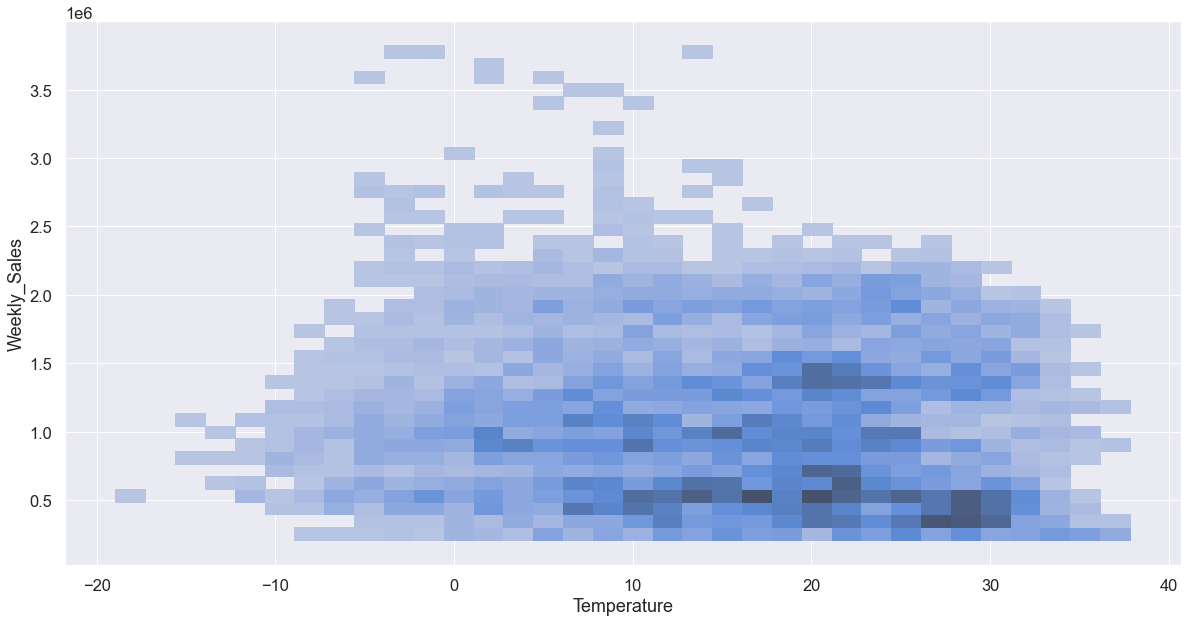

In [110]:
plt.figure(figsize=(20,10))
sns.histplot(x=df_train['Temperature'], y=df_train['Weekly_Sales'])
# 경향으로만 보면 온도가 좀 낮을 때 비싼 옷을 구매하는 경향이 있긴 있음

<AxesSubplot:xlabel='Temperature', ylabel='Weekly_Sales'>

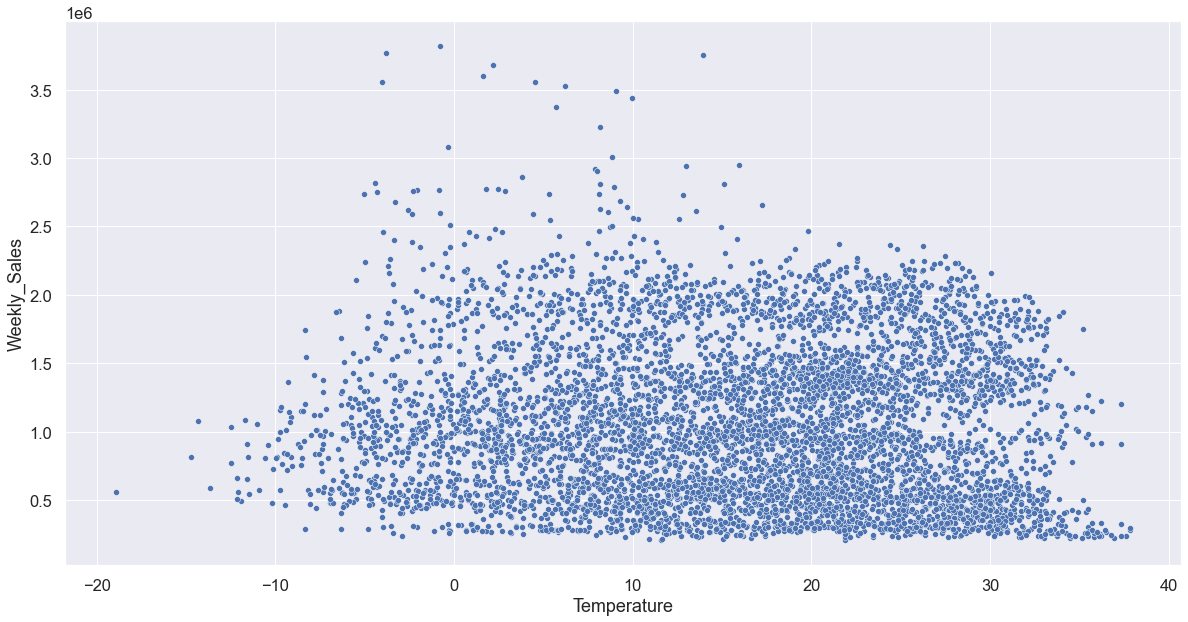

In [111]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=df_train['Temperature'], y=df_train['Weekly_Sales'])

#### 3. Fuel_Price

In [115]:
df_train.groupby('Store').agg({'Fuel_Price': ['mean','min','max']}).sort_values(by=('Fuel_Price','mean'),ascending = False)

# 달러 표시인듯
# 시기에 따라 가격이 달라지나요?

Fuel_Price          
            mean  min  max
Store                     
28          3.59 2.83 4.29
38          3.59 2.83 4.29
12          3.59 2.83 4.29
19          3.56 2.84 4.21
24          3.56 2.84 4.21
15          3.56 2.84 4.21
27          3.56 2.84 4.21
10          3.55 2.83 4.31
33          3.55 2.83 4.31
42          3.55 2.83 4.31
29          3.43 2.72 4.10
26          3.43 2.72 4.10
40          3.43 2.72 4.10
22          3.43 2.72 4.10
18          3.43 2.72 4.10
23          3.43 2.72 4.10
20          3.40 2.70 4.07
35          3.40 2.70 4.07
25          3.40 2.70 4.07
45          3.40 2.70 4.07
14          3.40 2.70 4.07
44          3.27 2.65 3.85
13          3.27 2.65 3.85
17          3.27 2.65 3.85
7           3.23 2.55 3.94
16          3.23 2.55 3.94
41          3.23 2.55 3.94
32          3.23 2.55 3.94
6           3.21 2.51 3.91
43          3.21 2.51 3.91
3           3.21 2.51 3.91
39          3.21 2.51 3.91
5           3.21 2.51 3.91
37          3.21 2.51 3.91
21          3.21 2.51 3.91
31          3.21 2.51 3.91
30          3.21 2.51 3.91
8           3.21 2.51 3.91
9           3.21 2.51 3.91
11          3.21 2.51 3.91
2           3.21 2.51 3.91
1           3.21 2.51 3.91
34          3.21 2.54 3.88
4           3.21 2.54 3.88
36          3.19 2.47 3.93

<AxesSubplot:xlabel='month', ylabel='Fuel_Price'>

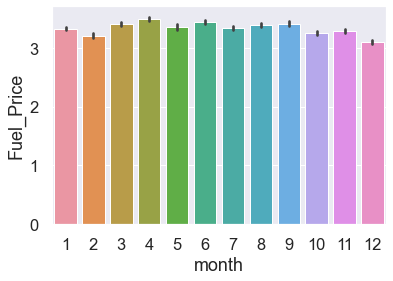

In [120]:
# sns.barplot(data= df_train, x = 'year', y = 'Fuel_Price') # 오르는 추세
sns.barplot(data= df_train, x = 'month', y = 'Fuel_Price') # 월별은 뭐 크게 차이없네
# seaborn이라 정수가 아닌 실수로 표현됨


<AxesSubplot:xlabel='Fuel_Price', ylabel='Weekly_Sales'>

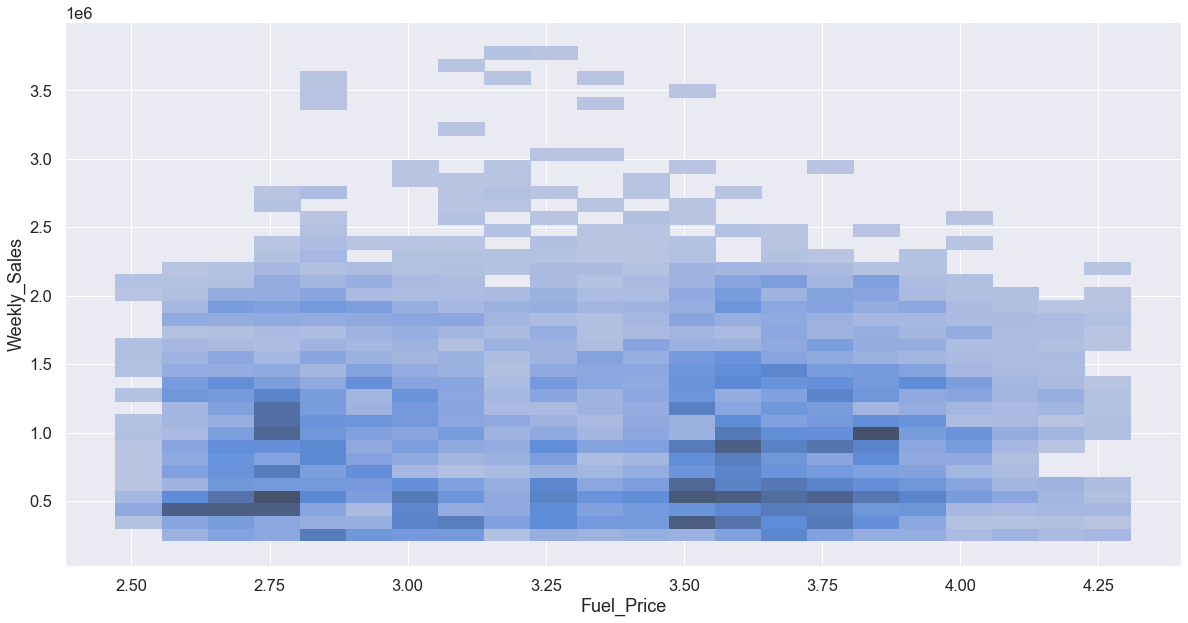

In [121]:
plt.figure(figsize=(20,10))
sns.histplot(x=df_train['Fuel_Price'], y=df_train['Weekly_Sales'])
# 경향성이 없는디

#### 4. Promotion

promotion1과 promotion4는 굉장히 유사
도대체 promotion이 뭐야  

언제 시작됐고, 어떤 특성이 있는지 확인

In [82]:
df_train['Promotion1']

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
6250    23641.30
6251    11024.45
6252    11407.95
6253     8452.20
6254     4556.61
Name: Promotion1, Length: 6255, dtype: float64

#### 5. Unemployment  
실업률과 매출의 연관이 있을까
연도별로 실업률은 증가하고 있는지, 감소하고 있는지
월별 실업률 비교


<AxesSubplot:xlabel='month', ylabel='Unemployment'>

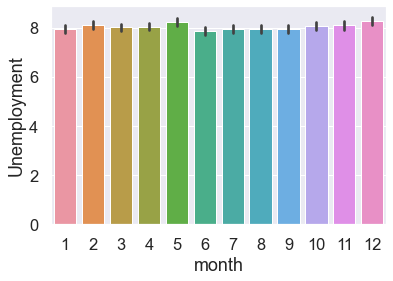

In [125]:
# sns.barplot(data=df_train, x = 'year', y ='Unemployment', estimator = np.mean) # 실업률은 감소
sns.barplot(data=df_train, x = 'month', y ='Unemployment') # 밸 차이없

In [129]:
# 평균 실업률이 가장 높은 지점
df_train.groupby('Store')['Unemployment'].mean().sort_values(ascending = False)

Store
28   13.20
38   13.20
12   13.20
43    9.97
34    9.97
29    9.83
18    8.86
35    8.79
14    8.65
45    8.65
7     8.62
32    8.62
33    8.58
24    8.44
10    8.40
42    8.40
22    8.08
27    8.00
15    8.00
19    8.00
36    7.92
39    7.92
37    7.92
26    7.89
21    7.67
2     7.67
30    7.67
31    7.67
1     7.64
25    7.37
20    7.37
11    7.21
3     7.21
13    7.04
41    7.00
44    6.78
6     6.64
17    6.58
16    6.50
5     6.32
9     6.13
8     6.12
4     6.02
40    4.81
23    4.81
Name: Unemployment, dtype: float64

## 3. Feature Engineering

1) 결측치 처리 - promotion 등 
2) 이상치 - log화 할 건지
3) 이외에 처리할 변수들 처리 (trian만 처리하고 test는 신경안썼던거)
4) drop할 변수들 확인

## 4. Modeling & submission

1) 어떤 모델쓰지? cate도 numeric도 같은 거 써도 되는건가? 찾아보기